In [199]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:
import functions.add_path

import functions.plotnine_theme
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from plotnine import *
from plotnine.data import *

import functions.et_condition_df as condition_df
import functions.et_make_df as  make_df
import be_load

In [201]:
import os
print(os.getcwd())
if os.getcwd()[-4:] != 'code':
    try:
        os.chdir('./code')
    except:
        os.chdir('/net/store/nbp/users/behinger/projects/etcomp/code')


/net/store/nbp/users/behinger/projects/etcomp/code


In [297]:
(etsamples,etmsgs,etevents) = be_load.load_data()

loading subject VP3 with et el
loading subject VP3 with et pl


In [203]:
#%% Do Smooth Pursuit Analysis
smooth = condition_df.get_condition_df(data=(etsamples,etmsgs,etevents),condition="SMOOTHPURSUIT")

CRITICAL:functions.et_condition_df:Eyetracker: el    Subject: VP1 
CRITICAL:functions.et_condition_df:Eyetracker: pl    Subject: VP1 
CRITICAL:functions.et_condition_df:Eyetracker: el    Subject: VP2 
CRITICAL:functions.et_condition_df:Eyetracker: pl    Subject: VP2 
CRITICAL:functions.et_condition_df:Eyetracker: el    Subject: VP3 
CRITICAL:functions.et_condition_df:Eyetracker: pl    Subject: VP3 
CRITICAL:functions.et_condition_df:Eyetracker: el    Subject: VP4 
CRITICAL:functions.et_condition_df:Eyetracker: pl    Subject: VP4 
CRITICAL:functions.et_condition_df:Eyetracker: el    Subject: VP11 
CRITICAL:functions.et_condition_df:Eyetracker: pl    Subject: VP11 
CRITICAL:functions.et_condition_df:Eyetracker: el    Subject: VP12 
CRITICAL:functions.et_condition_df:Eyetracker: pl    Subject: VP12 
CRITICAL:functions.et_condition_df:Eyetracker: el    Subject: VP14 
CRITICAL:functions.et_condition_df:Eyetracker: pl    Subject: VP14 
CRITICAL:functions.et_condition_df:Eyetracker: el    Sub

In [204]:
smooth_smooth  = smooth.query("type=='smoothpursuit' & condition=='SMOOTH' & exp_event=='trialstart'")
smooth_saccade = smooth.query("type=='saccade'       & condition=='SMOOTH' & exp_event=='trialstart'")

# HMM algorithm init times

In [ ]:
# Smooth Pursuit Init Times
smooth_smooth_first = smooth_smooth.groupby(["subject","block","trial"],as_index=False).first()
smooth_smooth_first.loc[:,'onsettime'] = smooth_smooth_first.start_time-smooth_smooth_first.msg_time

In [ ]:
ggplot(smooth_smooth_first,aes(x="et",y="onsettime",color="et"))+stat_summary()+stat_summary()

At first glance this looks promising. But if we look closer (next plot) we see that its all based on a lie

In [ ]:
select = "subject=='VP2'"

start = smooth_smooth.query(select+"&block==1").msg_time.iloc[0]

dur = 10#s
tmpdata = etsamples.query(select+"&smpl_time>%i & smpl_time <%i"%(start,start+dur))

In [ ]:
(ggplot(tmpdata,aes(x='smpl_time',y='gx',color="type"))+
 geom_point()+
#annotate("vline",aes(xintercept="msg_time"),data=smooth_smooth.query(select+"&block==1&msg_time<=%i"%(start+dur)),)+
 facet_wrap("~eyetracker"))

It became clear that the hmm algorithm is not good enough. The reason is that many fixations are detected as smooith pursuit events

# Piecewise Bayesian Regression
We have to do multiple steps:
- cut the data into epochs
- Rotate the data in the line of the smooth pursuit trajectory (and take only the main direction)
- Fit the Bayesiaan Piecewise Regression model
- Analyse the parameters

In [6]:
def makeRot(theta):
    theta = np.radians(theta)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s), (s, c)))
    return(R)
def rotate(gx,gy,theta):
    R = makeRot(theta).T
    out = np.dot(R,[gx,gy])
    return(out)
def rotateRow(row):
    #print(row[['angle','gx','gy']])
    theta = row.iloc[0].angle
    assert(len(row.angle.unique())==1)
    #print(theta)
    #print(row.gx)
    rot = rotate(row.gx.values,row.gy.values,theta)
    #print(rot[0])
    #print(len(rot[0]))
    #print(row.shape)
    row.loc[:,'rotated'] = rot[0]
    return(row)
    

In [ ]:
rotate(0,1,90)

In [ ]:
epochs = make_df.make_epochs(etsamples.query("eyetracker=='el'&subject=='VP11'"),etmsgs.query("subject=='VP11'&eyetracker=='el'&exp_event=='trialstart'&condition=='SMOOTH'"),td=[-0.1,1])

In [ ]:
rotateRow(epochs.iloc[[0,1,2]])

In [ ]:
epochs=  epochs.groupby("angle",group_keys=False).apply(rotateRow)

In [ ]:
epochs.rotated.unique()

In [ ]:
(ggplot(epochs,aes(x='td',y='rotated',color='vel'))+geom_point())

In [ ]:
epochs.columns

In [ ]:
d = epochs.query("trial==6&block==2&td<0.6")
datafit={'ntime': d.shape[0],
'etdata': d.rotated.values,
'time':d.td.values,
'tauprior':.185}

In [ ]:
plt.plot(datafit['time'],datafit['etdata'])

In [10]:
import SMOOTH

In [280]:
smoothresult = SMOOTH.fit_bayesian_model(etsamples,etmsgs)

msg 0 from 90
msg 50 from 90


/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


no saccade found
no saccade found
no saccade found
Elapsed time: 38.274823 seconds.

msg 0 from 90
msg 50 from 90


RuntimeError: []: accessing element out of range. index 0 out of range; expecting index to be between 1 and 0; index position = 1time

In [12]:
datapath='/net/store/nbp/projects/etcomp/'
smoothresult.to_csv(datapath+'stan_smooth_results.csv')

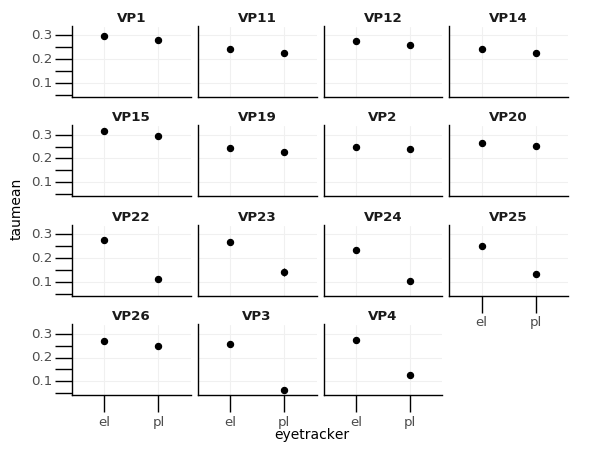

<ggplot: (8747247150810)>

In [13]:
ggplot(smoothresult,aes(x="eyetracker",y="taumean"))+stat_summary()+facet_wrap("~subject")

In [21]:
smoothresult = SMOOTH.load_smooth()

[autoreload of SMOOTH failed: Traceback (most recent call last):
  File "/home/student/b/behinger/.local/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/student/b/behinger/.local/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 626, in _exec
  File "<frozen importlib._bootstrap_external>", line 661, in exec_module
  File "<frozen importlib._bootstrap_external>", line 767, in get_code
  File "<frozen importlib._bootstrap_external>", line 727, in source_to_code
  File "<frozen i

AttributeError: module 'pandas' has no attribute 'from_csv'

In [310]:
def plot_single_trial(subject,eyetracker,trial,block,sm):
    select = "subject=='%s'&eyetracker=='%s'"%(subject,eyetracker)
    selectTrial = 'trial==%i&block==%i'%(trial,block)
    etmsgs2 = etmsgs.query(selectTrial)
    # temporary fix to align streams
    #if eyetracker=='pl':
    #    etmsgs2.loc[:,'msg_time'] = etmsgs2.loc[:,'msg_time']*.9999555986612232 +15.0431047803722322 + 0.04
    epochs = SMOOTH.get_smooth_data(etsamples,etmsgs2,select)
    out = epochs.query(selectTrial).groupby(["block","trial"]).apply(lambda row:SMOOTH.fitTrial(row,sm))

    fit =out.iloc[0]
    time = epochs.query(selectTrial).td
    def predict(offset,slope,time,tau,autocorr=150):
        w = 1. / (1. + np.exp(-(autocorr*(time-tau))))
        act =  offset +  w *  (slope * (time-tau))#+np.random.normal(0,0.5,len(time))
        return(act)
    def predict_stan(fit,time):
        post =pd.DataFrame(fit.extract())
        if 'autocorrfactor' in post.columns:
            act = post.sample(n=25).apply(lambda row:predict(row.offset,row.slope,time,row.tau,row.autocorrfactor),axis=1)
        else:
            act = post.sample(n=25).apply(lambda row:predict(row.offset,row.slope,time,row.tau),axis=1)
        return(act.values)

    act = predict_stan(fit,time)
    [plt.plot(time,act[i,:],'k',alpha=0.1) for i in range(act.shape[0])]
    plt.plot(time,epochs.query(selectTrial).rotated)
    plt.plot(np.mean(fit.extract()['tau']),0,'ro')
    #print(np.mean(fit.extract()['tau']))
    return fit

In [233]:
sm =SMOOTH.compileModel('changepoint.stan')
#sm2 =SMOOTH.compileModel('changepoint2.stan')

msg 0 from 1


/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


msg 0 from 1


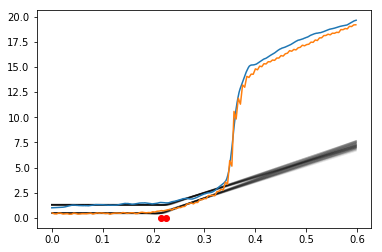

In [314]:
subject = 'VP3'
block = 5
fit = dict()
fit['el'] = plot_single_trial(subject,'el',10,block,sm)
fit['pl'] = plot_single_trial(subject,'pl',10,block,sm)

In [269]:
fit['pl']

Inference for Stan model: anon_model_8875299d4f0849455d5b6cf28abae5ce.
1 chains, each with iter=1500; warmup=300; thin=1; 
post-warmup draws per chain=1200, total post-warmup draws=1200.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma    0.14  4.7e-4   0.01   0.11   0.13   0.14   0.15   0.17    922    1.0
slope    4.08    0.03   0.75   2.77   3.53   4.02   4.53   5.66    722    1.0
offset  -0.11  8.2e-4   0.02  -0.16  -0.12  -0.11  -0.09  -0.06    821    1.0
tau      0.12  4.0e-4   0.01    0.1   0.12   0.12   0.13   0.15    726    1.0
lp__    79.14    0.07   1.52  75.44  78.28  79.48  80.27  81.14    467    1.0

Samples were drawn using NUTS at Fri Aug  3 13:58:27 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [ ]:
#%% Do Smooth Pursuit Analysis
smooth = condition_df.get_condition_df(data=(etsamples,etmsgs,etevents),condition="SMOOTHPURSUIT")

In [ ]:
smooth_saccade_agg = smooth_saccade.groupby(["subject","et","block","trial","angle","vel"],as_index=False).agg({'amplitude':np.mean})
ggplot(smooth_saccade_agg,aes(x="vel",y="amplitude",color="et"))+stat_summary()+ylab('Number of Catchup Saccades')

In [ ]:
smooth_smooth  = smooth.query("type=='smoothpursuit' & condition=='SMOOTH' & exp_event=='trialstart'")
smooth_saccade = smooth.query("type=='saccade'       & condition=='SMOOTH' & exp_event=='trialstart'")

In [ ]:
ggplot(smooth_saccade_agg,aes(x="amplitude",group="subject"))+geom_density()+facet_grid("et~.")

In [ ]:
# Smooth Pursuit Init Times
smooth_smooth_first = smooth_smooth.groupby(["subject","block","trial"],as_index=False).first()
smooth_smooth_first.loc[:,'onsettime'] = smooth_smooth_first.start_time-smooth_smooth_first.msg_time

In [ ]:
ggplot(smooth_smooth_first,aes(x="et",y="onsettime",color="et"))+stat_summary()

In [ ]:
smooth_saccade_agg = smooth_saccade.groupby(["subject","et","block","trial","angle","vel"],as_index=False).agg({'amplitude':np.mean})
ggplot(smooth_saccade_agg,aes(x="vel",y="amplitude",color="et"))+stat_summary()+ylab('Number of Catchup Saccades')

In [ ]:
select = "subject=='VP2'"

start = smooth_smooth.query(select+"&block==1").msg_time.iloc[0]

In [ ]:
ggplot(smooth_smooth_first,aes(x="et",y="onsettime",color="et"))+geom_point()+facet_wrap("~subject")